In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import cv2

import matplotlib  as mpl 
import matplotlib.pyplot as plt 
import plotly.express as px

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(15, 12)) #(10, 6)
mpl.rc('image', cmap='gray')

In [12]:
my_img = pims.open('tiff_series_part_counter/*.tif')
my_img

<Frames>
Source: /Users/miroshni/Documents/Unifr/Unifr_work/glass_transition_in_emulsions/TrackPy/microgels/feb20/S6/tiff_series_part_counter/*.tif
Length: 153 frames
Frame Shape: (193, 204)
Pixel Datatype: uint8

In [13]:
from stardist.models import StarDist2D, Config2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [14]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


(-0.5, 203.5, 192.5, -0.5)

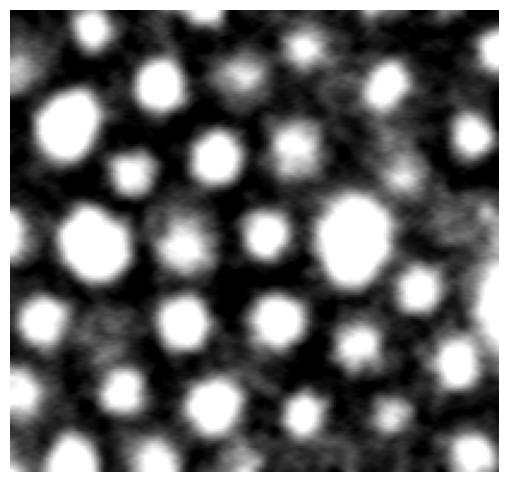

In [15]:
plt.figure(figsize=(9, 6))
plt.imshow(my_img[0], cmap='gray')
plt.axis('off')

In [16]:
@pims.pipeline
def stardist_segm(img):
    img_labels, img_details = model.predict_instances(normalize(img, 1.0, 99.8), prob_thresh=0.75, nms_thresh=0.75)
    return img_labels

In [17]:
label_image = stardist_segm(my_img)

Text(0.5, 1.0, 'prediction + input overlay')

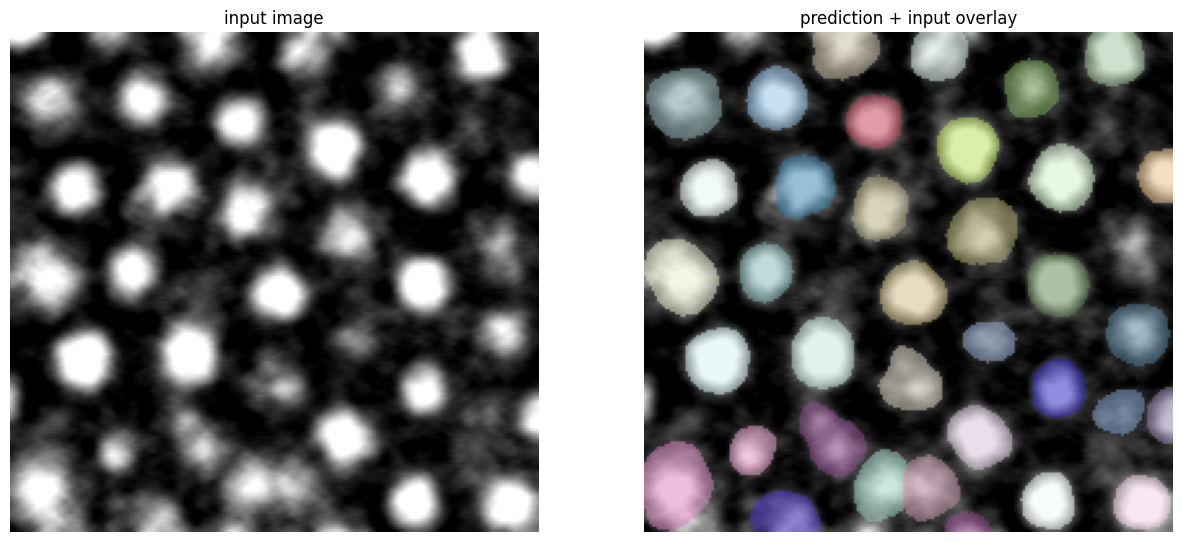

In [19]:
img_num = 30

plt.subplot(1, 2, 1)
plt.imshow(my_img[img_num], cmap='gray')
plt.axis('off')
plt.title('input image')

plt.subplot(1, 2, 2)
plt.imshow(render_label(label_image[img_num], img=my_img[img_num]))
# plt.imshow(he_labels)
plt.axis('off')
plt.title('prediction + input overlay')

In [20]:
import skimage

In [21]:
%%time
features = pd.DataFrame()

for num, img in enumerate(my_img):
    for region in skimage.measure.regionprops(label_image[num], intensity_image=img):
        # store fuatures
        dataset = pd.DataFrame({
            'y': [region.centroid[0]],
            'x': [region.centroid[1]],
            'frame': [num],
            'area': [region.area],
            'brightness': [region.intensity_mean],
        })
        
        features = pd.concat([features, dataset])

CPU times: user 1min 25s, sys: 35.5 s, total: 2min
Wall time: 18.3 s


In [22]:
features.head

<bound method NDFrame.head of              y           x  frame   area  brightness
0    31.218137  156.531863      0  408.0  193.710784
0    31.134653   62.603960      0  505.0  192.546535
0    58.084270  118.812734      0  534.0  166.138577
0    93.081013  106.265823      0  395.0  192.098734
0   116.198347  170.542700      0  363.0  196.393939
..         ...         ...    ...    ...         ...
0   111.368421  267.118421    152  228.0  111.197368
0   214.639706  182.746324    152  272.0   84.136029
0   306.214447  150.462754    152  443.0   82.462754
0   360.689922  156.465116    152  258.0   62.782946
0   204.901141  215.923954    152  263.0   94.224335

[15507 rows x 5 columns]>

In [23]:
features.to_csv('data_out/S6_part_counter.csv', index=False)

In [51]:
# read 'features' from file 
features = pd.read_csv('data_out/S6_part_counter.csv')

In [52]:
# create copy of features to make modifications
features_modif = features.copy()

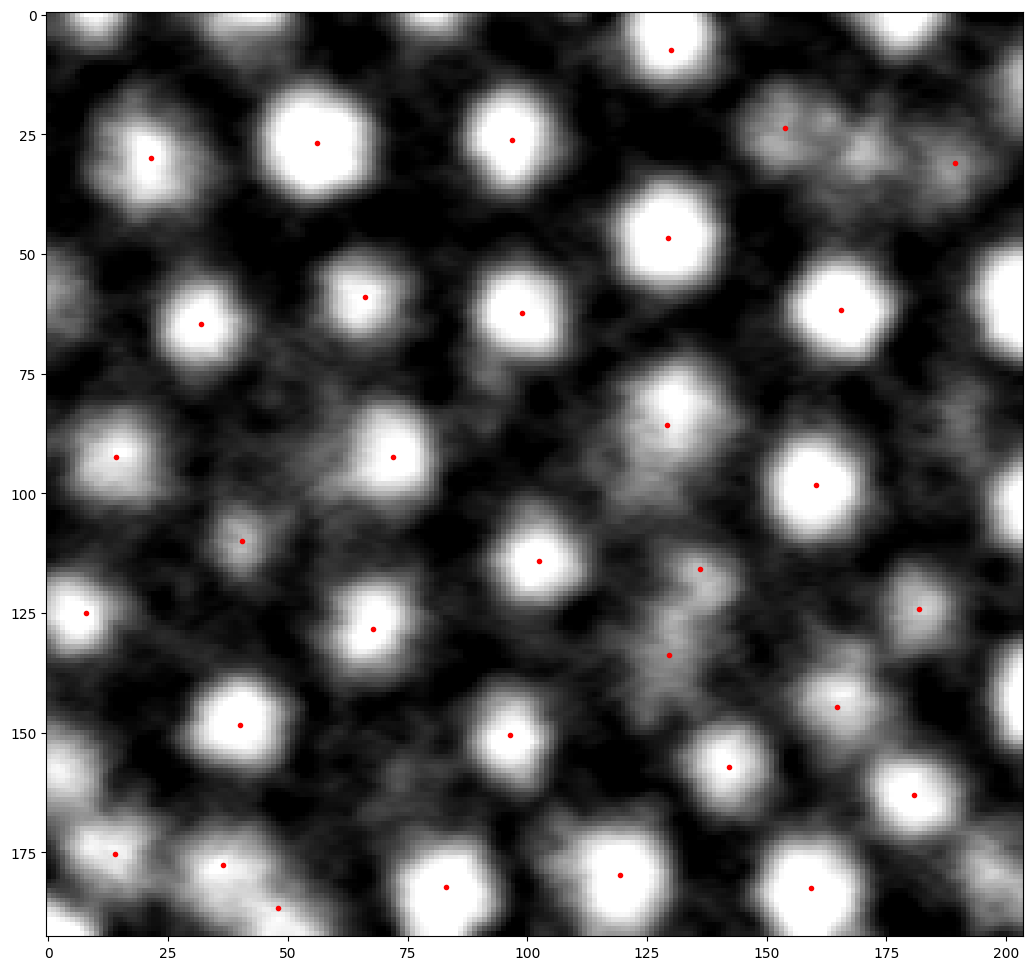

In [53]:
tp.annotate(features_modif[features_modif.frame==(15)], my_img[15], plot_style={'markersize':2});

In [54]:
# plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not

# fig = px.histogram(features_modif['area'], nbins=20, template="simple_white")

# fig.show()

In [55]:
# filter out by area (make the histogram looks more or less normal distrubution)

# features_modif = features_modif.loc[(features_modif['area'] > 40)]

In [56]:
# plot new histogram

# fig = px.histogram(features_modif['area'], nbins=20, template="simple_white")

# fig.show()

In [57]:
# plot the brightness (called as 'mass' in trackpy)

fig = px.histogram(features_modif['brightness'], template="simple_white")

fig.show()

In [58]:
# filter out by intensity, then give it the name feature as it was originally

features_modif = features_modif.loc[(features_modif['brightness'] > 140)]

In [59]:
# plot the brightness (called as 'mass' in trackpy)

fig = px.histogram(features_modif['brightness'], template="simple_white")

fig.show()

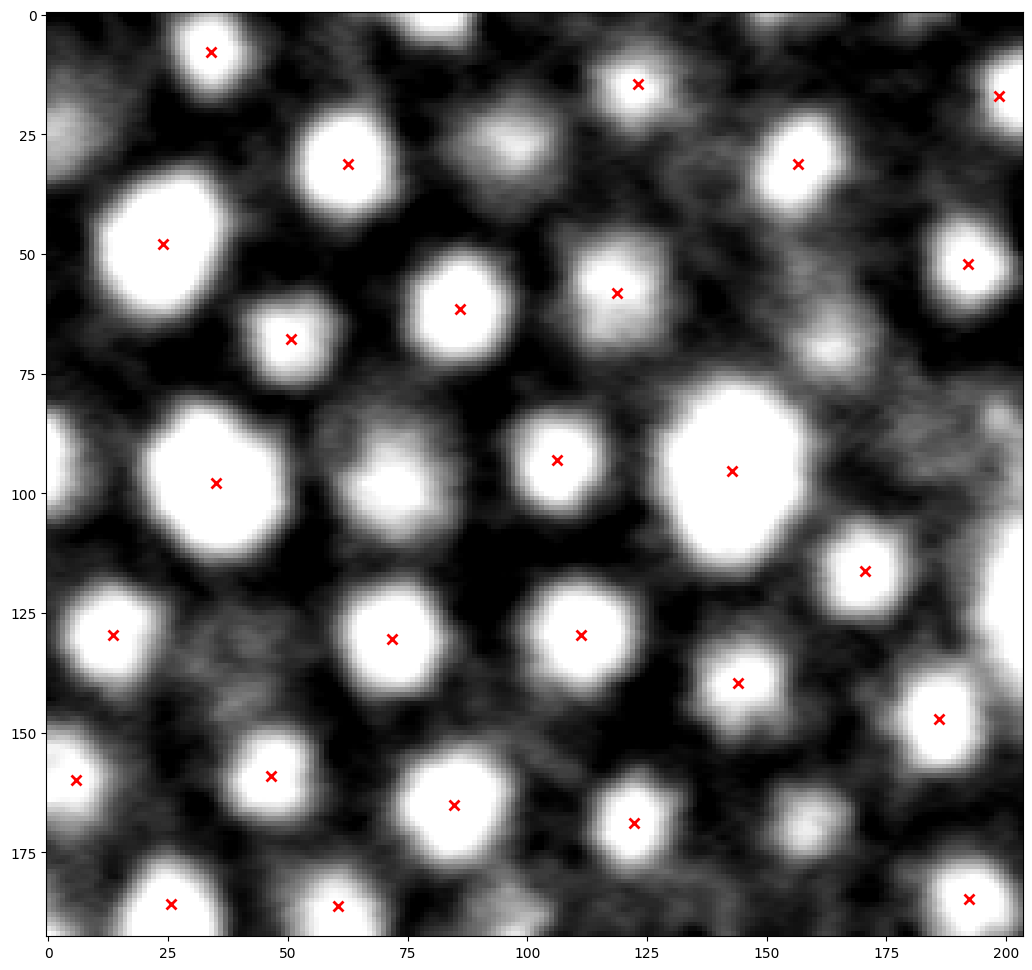

<Axes: >

In [65]:
tp.annotate(features_modif[features_modif.frame==(0)], my_img[0], plot_style={'markersize':7, 'marker':'x'})

In [63]:
NOPdf = pd.DataFrame(columns=['slice', 'count'])

max_frame = features_modif.frame.iloc[-1]

for fr in range(max_frame + 1):
    mask = features_modif[features_modif.frame == fr]
    number = mask.x.count()
    
    NOPdf.loc[len(NOPdf.index)] = [fr, number]

NOPdf.head()

,slice,count
0,0,26
1,1,25
2,2,23
3,3,24
4,4,23


In [64]:
# Save data to .dat file
np.savetxt('../scripts/input_data/slice_count_S6.dat', NOPdf, header="slice count", fmt='%d')